## **1. Importing Libraries**

In [96]:
import pickle
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

## **2. Loading Dataset**

In [69]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_train_data(directory, filenum):
    data = []
    for i in range(1, filenum + 1):
        filename = os.path.join(directory, f"data_batch_{i}")
        batch_data = unpickle(filename)
        data.append(batch_data)
    return data

def load_test_data(directory,fname):
    filename = os.path.join(directory, fname)
    tdata = unpickle(filename)
    return tdata

def formTrainImages(dataset):
    image_data = []
    for class_idx in range(10):
        images_of_class = []
        for batch in dataset:
            data = batch[b'data']
            labels = batch[b'labels']
            for i in range(len(labels)):
                if labels[i] == class_idx:
                    image = data[i].reshape(3, 32, 32).transpose(1, 2, 0)
                    images_of_class.append(image)

        image_data.append(images_of_class)
    
    return image_data

def formTestImages(dataset):
    image_data = []
    for class_idx in range(10):
        images_of_class = []
        data = dataset[b'data']
        labels = dataset[b'labels']
        for i in range(len(labels)):
            if labels[i] == class_idx:
                image = data[i].reshape(3, 32, 32).transpose(1, 2, 0)
                images_of_class.append(image)

        image_data.append(images_of_class)
    
    return image_data

def displayRandom(image_data, num):
    for class_idx in range(len(image_data)):
        selected_indices = np.random.choice(len(image_data[class_idx]), num, replace=False)
        plt.figure(figsize=(8, 8))
        for i, idx in enumerate(selected_indices):
            random_image = image_data[class_idx][idx]
            plt.subplot(1, num, i+1)
            plt.imshow(random_image)
            plt.axis('off')
        plt.show()
        
def split_dataset(image_data):
    X_train, X_validation, y_train, y_validation= [], [], [], []
    
    for class_idx, images in enumerate(image_data):
        labels = [class_idx] * len(images)
        images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=None)
        
        X_train.extend(images_train)
        X_validation.extend(images_test)
        y_train.extend(labels_train)
        y_validation.extend(labels_test)
    
    return X_train, X_validation, y_train, y_validation

def process_test_data(image_data):
    X_test, y_test = [], []
    
    for class_idx, images_of_class in enumerate(image_data):
        X_test.extend(images_of_class)
        y_test.extend([class_idx] * len(images_of_class))

    return X_test, y_test


In [70]:
train_data = load_train_data('/kaggle/input/cifar-10',5)
test_data = load_test_data('/kaggle/input/cifar-10','test_batch')

In [71]:
train_images = formTrainImages(train_data)
test_images = formTestImages(test_data)

## **3. Displaying samples**

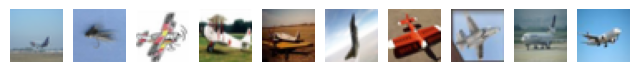

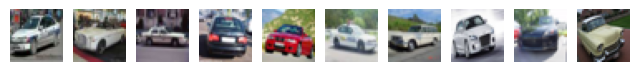

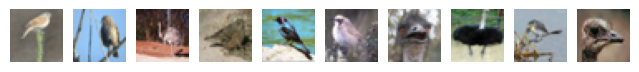

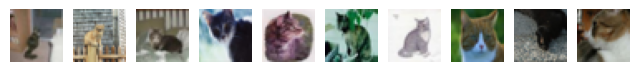

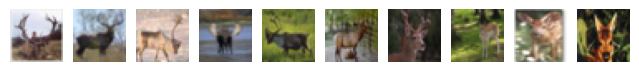

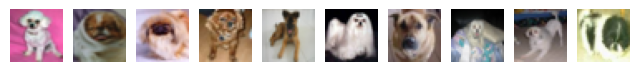

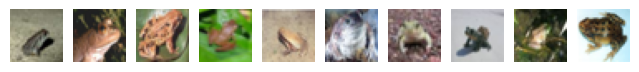

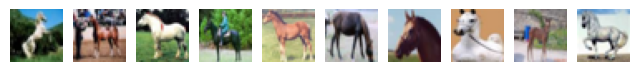

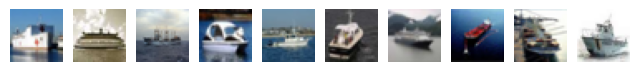

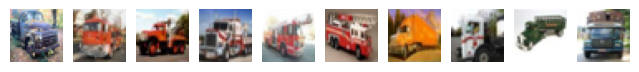

In [72]:
displayRandom(train_images, 10)

## **4. Processing data**

In [73]:
#splitting training and validation datasets
X_train, X_validation, y_train, y_validation = split_dataset(train_images)
X_test, y_test = process_test_data(test_images)

In [75]:
#performing one hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_validation = to_categorical(y_validation, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [76]:
#regularization of data
X_train = np.array(X_train) / 255.0
X_validation = np.array(X_validation) / 255.0
X_test = np.array(X_test) / 255.0

## **5. Preparing model and tuning hyperparameters**

In [77]:
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=16), 
                     (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=16), 
                     (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Conv2D(hp.Int('conv3_units', min_value=32, max_value=128, step=16), 
                     (3, 3), activation='relu'))
    model.add(Conv2D(hp.Int('conv4_units', min_value=32, max_value=128, step=16), 
                     (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=128), 
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [78]:
#using tuner from keras to find best hyperparameters for our model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
)

tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_validation, y_validation),
             callbacks=[early_stopping, reduce_lr])

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./untitled_project/tuner0.json
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7997ea4198a0>


In [79]:
#data augmentation to prevent overfitting
datagen = ImageDataGenerator(rotation_range=15,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True)
datagen.fit(X_train)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

## **6. Model training**

In [80]:
model = tuner.hypermodel.build(best_hp)
history = best_model.fit(datagen.flow(X_train, y_train, batch_size=64),
                         epochs=20,
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping, reduce_lr], verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.2629 - loss: 1.9670 - val_accuracy: 0.4532 - val_loss: 1.4901 - learning_rate: 2.0274e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4442 - loss: 1.5172 - val_accuracy: 0.5329 - val_loss: 1.2980 - learning_rate: 2.0274e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5018 - loss: 1.3822 - val_accuracy: 0.5407 - val_loss: 1.3139 - learning_rate: 2.0274e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.5392 - loss: 1.2853 - val_accuracy: 0.5606 - val_loss: 1.2426 - learning_rate: 2.0274e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5622 - loss: 1.2166 - val_accuracy: 0.6314 - val_loss: 1.0439 - learning_rate: 2.0274e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5935 - loss: 1.1465 - val_accuracy: 0.6480 - val_loss: 0.9917 - learning_rate: 2.0274e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accurac

## **7. Model evaluation**

In [81]:
validation_loss, validation_acc = best_model.evaluate(X_validation, y_validation)
print('Validation accuracy:', validation_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7210 - loss: 0.7890


In [86]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7201 - loss: 0.8019
Test accuracy: 0.753000020980835


## **8. Plotting training and validation loss and accuracy**

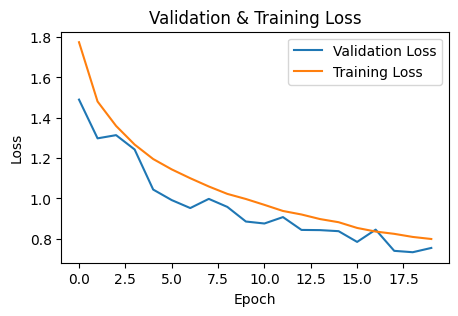

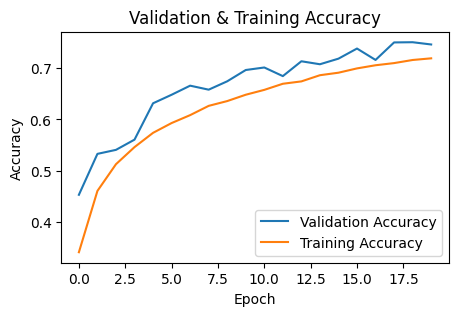

In [90]:
plt.figure(figsize=(5, 3)) 
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Validation & Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Validation & Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **9. Classification report**

In [95]:
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Calculate top-5 accuracy
top_5_accuracy = top_k_accuracy_score(y_test_indices, y_pred, k=5)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro')
recall = recall_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
top_5_accuracy = top_k_accuracy_score(y_test_indices, y_pred, k=5)

# Display results in tabular form
print("Evaluation Metrics:")
print("="*20)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Top-5 Accuracy: {top_5_accuracy}")
print("\nClassification Report:")
print("="*20)
print(classification_report(y_test_labels, y_pred_labels))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation Metrics:
Accuracy: 0.753
Precision: 0.755911587067799
Recall: 0.753
F1-Score: 0.7489308966724904
Top-5 Accuracy: 0.9839

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1000
           1       0.87      0.87      0.87      1000
           2       0.74      0.59      0.66      1000
           3       0.64      0.51      0.57      1000
           4       0.75      0.67      0.71      1000
           5       0.69      0.64      0.66      1000
           6       0.64      0.91      0.75      1000
           7       0.82      0.79      0.81      1000
           8       0.82      0.89      0.86      1000
           9       0.74      0.91      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



## **10. Confusion matrix**

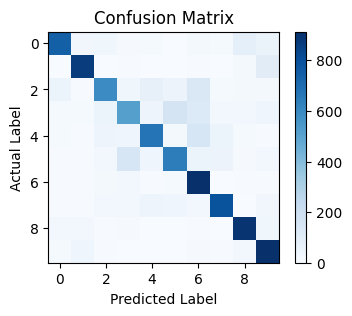

In [100]:
conf_matrix = confusion_matrix(y_test_indices, y_pred_labels)
plt.figure(figsize=(4, 3))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

## **11. ROC curve and AUC**

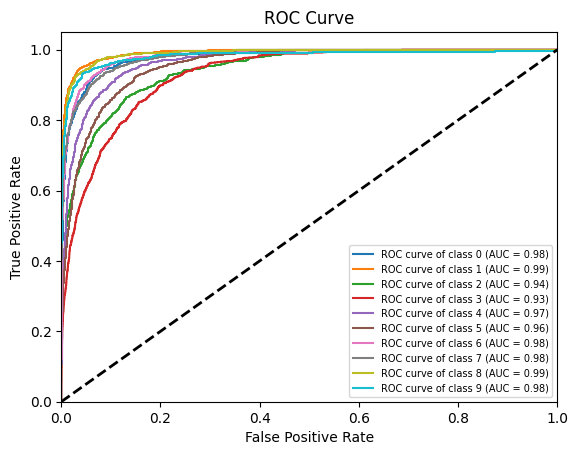

In [110]:
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", fontsize=7)
plt.show()